In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
from datetime import timedelta

## Data Engineering

In [2]:
def data_engineering(path='sample.csv'):
    import numpy as np
    from numpy import genfromtxt
    a1 = genfromtxt('sample.csv', delimiter=',')
    a2 = np.transpose(a1)
    df2 = pd.DataFrame(a2, index=None,columns = ['date','volume'])
    df2['date'] = df2['date'].astype(str)
    df2['week_no'] = df2['date'].apply(lambda x:x[-4:])
    df2['year'] = df2['date'].apply(lambda x:x[0:4])
    df2['counter'] = range(df2.shape[0])
    first_sunday = datetime.strptime('2015-01-04','%Y-%m-%d').date()
    df2['date2'] = df2['counter'].apply(lambda x:first_sunday + timedelta(days= 7*x) )
    df2['day_of_week_chk']= df2['date2'].apply(lambda x:x.isoweekday())
    df3 = df2[['date2','volume']]
    df3 = df3.rename({'date2':'ds','volume':'y'},axis = 1)
    return df3
    

In [3]:
df2 = data_engineering()

In [4]:
df2.plot(figsize = (15,10))

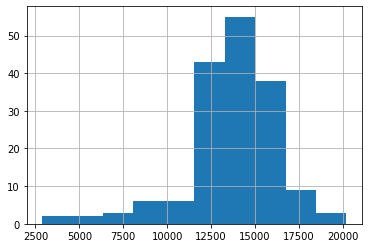

In [5]:
df2['y'].hist()

## Seasonality and Trend

### Seasonality and Trend Detection
In this step, please write a function which takes in the output from the data engineering step and leverages the Gaussian process to extract seasonality and trend.

### Input specifications:

A positional input which takes in the output from the previous step.

An optional input which is an integer indication how many data points to predict, defaults to 6.

### Output specifications:

This function returns two DataFrame objects of the same format as the input. The first DataFrame object indicates the seasonality and trend detected. The second DataFrame object contains the residue of subtracting the seasonality and trend from the input.

Both outputs would have n number of extra rows in the end where n is the same as the integer indicated by the optional input.

For the first output, the n extra rows contains predicted seasonality and trend of the next n weeks .

For the second output, the ds column should be filled for the n extra rows but the y column should be left as numpy.nan. They will be filled during the next step.

### Requirements:

The process of hyper-parameter tuning must be automated.

Set the second parameter to 6.

# Grid Search on GP

In [6]:
def Seasonality_Trend(dataframe,n=6):
    dataframe_c = dataframe.copy()
    df3 = dataframe
    from sklearn.gaussian_process.kernels import RBF
    from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel
    from sklearn.model_selection import GridSearchCV
    from sklearn.gaussian_process import GaussianProcessRegressor

    #df3 = data_engineering()


    from scipy.stats import chi2
    no = df3.shape[0]
    alpha = 0.05
    s = df3['y'].std()
    c_LL = chi2.ppf(alpha/2, no-1)
    c_UL = chi2.ppf( 1 - (alpha/2), no-1)
    s_LL = np.sqrt((no-1) * s**2/(c_UL))
    s_UL = np.sqrt((no-1) * s**2/(c_LL))


    noise_constant = 0.01 
    k0 = WhiteKernel(noise_level= noise_constant*df3.std()['y']**2, noise_level_bounds=(noise_constant*s_LL**2,noise_constant*s_UL**2))
    noise_constant = 0.2
    df3['week'] = df3['ds'].apply(lambda x:x.isocalendar()[1])
    df3['days'] = df3['ds'].apply(lambda x: (x - df3.iloc[0]['ds']).days)
    k_seasonal = ConstantKernel(constant_value=10,constant_value_bounds=(1e-2, 1e3)) * ExpSineSquared(length_scale=1.0, periodicity=40, periodicity_bounds=(10, 60))

    k_linear = ConstantKernel(constant_value=10, constant_value_bounds=(1e-2, 1e3)) * RBF(length_scale=100.0, length_scale_bounds=(1, 1e4)) 
    k_S = k_seasonal +k0
    k_L = k_linear +k0
    k_C = k_linear+k0 + k_seasonal




    #params = {'n_restarts_optimizer':[0,5,10],'alpha':np.logspace(-6, 6, num=10, base=10.0),'kernel__k2__noise_level':np.logspace(1, 6, num=10, base=10.0)}
    #params2 = {'n_restarts_optimizer':[0,5,10],'alpha':np.logspace(-5, 8, num=10, base=10.0), 'kernel__k2__noise_level':np.logspace(1, 6, num=10, base=10.0)}
    params3_1 = { 'kernel__k2__noise_level':np.logspace(1, 3, num=40, base=10.0),'kernel__k1__k2__length_scale':np.linspace(1, 100, num=10)}
    params3_2 = { 'kernel__k2__noise_level':np.logspace(1, 3, num=40, base=10.0),'kernel__k1__k2__periodicity':np.linspace(20, 60, num=10),
                'kernel__k1__k2__length_scale':np.linspace(1, 100, num=10)}
    params3_3 = { 'kernel__k1__k2__noise_level':np.logspace(1, 3, num=40, base=10.0),\
                 'kernel__k1__k1__k2__length_scale':np.linspace(1, 100, num=10),'kernel__k2__k2__periodicity':np.linspace(20, 60, num=10)}

    prop_train = 0.7
    n = df3.shape[0]
    n_train = round(prop_train*n)
    X = np.array(df3['days']).reshape(df3['days'].shape[0],1)
    y = np.array(df3['y']).reshape(df3['y'].shape[0],1)

    gp_L = GaussianProcessRegressor(
        kernel=k_L, 
        normalize_y=True)

    gp_S = GaussianProcessRegressor(
        kernel=k_S, 
        normalize_y=True)

    gp_C = GaussianProcessRegressor(
        kernel=k_C, 
        normalize_y=True)

    gp_L_search = GridSearchCV(gp_L,params3_1,scoring='neg_mean_squared_error',cv = 3, verbose=2,n_jobs = 3)

    gp_S_search = GridSearchCV(gp_S,params3_2,scoring='neg_mean_squared_error',cv = 3, verbose=2,n_jobs = 3)

    gp_C_search = GridSearchCV(gp_C,params3_3,scoring='neg_mean_squared_error',cv = 3, verbose=2,n_jobs = 3)

    gp_L_search.fit(X,y)

    gp_S_search.fit(X,y)

    gp_C_search.fit(X,y)

    gp_L_b = gp_L_search.best_estimator_
    gp_S_b = gp_S_search.best_estimator_
    y_trend = gp_L_b.predict(X)
    y_seasonality = gp_S_b.predict(X)

    df3['Trend'] = y_trend
    df3['Seasonality'] = y_seasonality

    #---------------Plot Results-----------------------------------------
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig, ax = plt.subplots()


    sns.lineplot(x='days', y='y', data=df3, label = 'y', ax=ax)
    sns.lineplot(x='days', y='Trend', data=df3, label='Trend', color='black', ax=ax)
    sns.lineplot(x='days', y='Seasonality', data=df3, label='Seasonality', color='red', ax=ax)
    ax.set(title='Prediction Sample 2', xlabel='days', ylabel='')
    ax.legend(loc='upper left')
    plt.show()

    #------Giving the Output in the Desired Format----------------------------------------------------
    #df2 = data_engineering()
    df2 = dataframe_c
    #n = 6
    df2['week'] = df2['ds'].apply(lambda x:x.isocalendar()[1])
    df2['days'] = df2['ds'].apply(lambda x: (x - df2.iloc[0]['ds']).days)
    df_add = pd.DataFrame(columns = df2.columns.tolist())
    df_add['counter'] =range(1,7)
    last_date = df2.iat[df2.shape[0]-1,0]
    last_day = df2.iat[df2.shape[0]-1,3]
    last_week = df2.iat[df2.shape[0]-1,2]

    df_add['ds'] = df_add['counter'].apply(lambda x:last_date+timedelta(days=x*7))
    df_add['days'] = df_add['counter'].apply(lambda x:last_day + x*7)
    df_add['week'] = df_add['counter'].apply(lambda x: last_week +x )
    df_add2 = df_add[['days','ds','week','y']]
    df_comb = pd.concat([df2,df_add2])

    X_C = np.array(df_comb['days']).reshape(df_comb['days'].shape[0],1)
    y_C = np.array(df_comb['y']).reshape(df_comb['y'].shape[0],1)
    trend_pred = gp_L_b.predict(X_C)
    season_pred = gp_S_b.predict(X_C)
    gp_C_b = gp_C_search.best_estimator_
    y_pred = gp_C_b.predict(X_C)
    df_comb['trend_pred'] = trend_pred
    df_comb['season_pred'] = season_pred
    df_comb['y_pred'] = y_pred
    df_comb2 = df_comb.copy()
    df_comb2['y_res']=df_comb2['y']-df_comb2['y_pred']
    #---------------------------------------------------------------------------
    # The additional n rows in the dataframe are filled with the predictions of the the sesonality+Trend model
    df_res1 = df_comb.rename({'ds':'ds','y_pred':'y_trend_plus_season','y':'y','trend_pred':'trend_pred','season_pred':'season_pred'},axis = 1)
    df_res1['y'] = np.where(df_res1['y'].isnull(),df_res1['y_trend_plus_season'],df_res1['y'])
    df_res1x = df_res1[['ds','y','trend_pred','season_pred','y_trend_plus_season']]
    #-----------------------------------------------------------------------------------
    # Dataframe after subtracting Trend+Seasonality from y
    df_res2 = df_comb2[['ds','y','y_res','y_pred','trend_pred','season_pred']]
    df_res2['y'] = df_res2['y_res']
    df_res2x = df_res2[['ds','y']]
    return df_res1x, df_res2x


In [7]:
#gp_S.get_params().keys()
#gp_C.get_params().keys()
#gp_L.get_params().keys()

In [8]:
df0x = data_engineering()


Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  97 tasks      | elapsed:    2.0s
[Parallel(n_jobs=3)]: Done 1065 tasks      | elapsed:   12.2s
[Parallel(n_jobs=3)]: Done 1200 out of 1200 | elapsed:   13.8s finished
C:\Users\ritvik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 4000 candidates, totalling 12000 fits


[Parallel(n_jobs=3)]: Done 180 tasks      | elapsed:    5.2s
[Parallel(n_jobs=3)]: Done 906 tasks      | elapsed:   26.0s
[Parallel(n_jobs=3)]: Done 2124 tasks      | elapsed:   50.8s
[Parallel(n_jobs=3)]: Done 3822 tasks      | elapsed:  1.4min
[Parallel(n_jobs=3)]: Done 6012 tasks      | elapsed:  2.2min
[Parallel(n_jobs=3)]: Done 8682 tasks      | elapsed:  3.1min
[Parallel(n_jobs=3)]: Done 11844 tasks      | elapsed:  4.2min
[Parallel(n_jobs=3)]: Done 12000 out of 12000 | elapsed:  4.2min finished
C:\Users\ritvik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 3 folds for each of 4000 candidates, totalling 12000 fits


[Parallel(n_jobs=3)]: Done  64 tasks      | elapsed:    3.6s
[Parallel(n_jobs=3)]: Done 306 tasks      | elapsed:   17.3s
[Parallel(n_jobs=3)]: Done 712 tasks      | elapsed:   40.7s
[Parallel(n_jobs=3)]: Done 1278 tasks      | elapsed:  1.2min
[Parallel(n_jobs=3)]: Done 2008 tasks      | elapsed:  2.0min
[Parallel(n_jobs=3)]: Done 2898 tasks      | elapsed:  2.9min
[Parallel(n_jobs=3)]: Done 3952 tasks      | elapsed:  4.1min
[Parallel(n_jobs=3)]: Done 5166 tasks      | elapsed:  5.4min
[Parallel(n_jobs=3)]: Done 6544 tasks      | elapsed:  6.9min
[Parallel(n_jobs=3)]: Done 8082 tasks      | elapsed:  8.7min
[Parallel(n_jobs=3)]: Done 9784 tasks      | elapsed: 10.4min
[Parallel(n_jobs=3)]: Done 11646 tasks      | elapsed: 12.4min
[Parallel(n_jobs=3)]: Done 12000 out of 12000 | elapsed: 12.8min finished
C:\Users\ritvik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.2

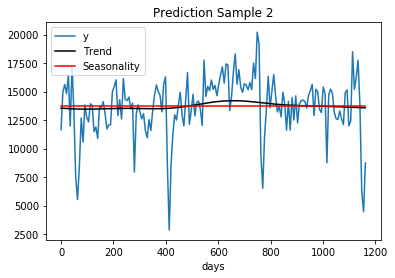

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:112: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
df1, df2 = Seasonality_Trend(df0x,n=6)

In [10]:
df2_c = df2.copy()

## Model Comparisons and Prediction

In [11]:
def Model_comparison_prediction(df2_c):
    # Feature Creation
    df2_c['month'] = df2_c['ds'].apply(lambda x:x.month)
    df2_c['week'] = df2_c['ds'].apply(lambda x:x.isocalendar()[1])
    df2_c['days'] = df2_c['ds'].apply(lambda x: (x - df2_c.iloc[0]['ds']).days)
    df2_c['ones'] = np.ones(df2_c.shape[0])
    df2_tr = df2.iloc[0:df0x.shape[0]]
    df2_m= df2_c.groupby(['month']).agg({'y':'sum','ones':'sum'})
    df2_m['y_avg'] = df2_m['y']/df2_m['ones']
    df2_m2 = df2_m[['y_avg']]
    df2_m1 = df2_c.merge(df2_m2.reset_index(),on = ['month'], how = 'left')
    for i in range(7,14):
        df2_m1['y_lag'+str(i)] = df2_m1['y'].shift(i)
    # Impute Nan Values for Lag
    from sklearn.impute import SimpleImputer
    data_df = df2_m1[['ds','y','days','month','y_avg','y_lag7','y_lag8','y_lag9','y_lag10','y_lag11','y_lag12','y_lag13']].set_index('ds')
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean.fit(data_df)
    data_df2 = imp_mean.transform(data_df)
    data_df2 = pd.DataFrame(data_df2,columns = data_df.columns.tolist())
    data_tr = data_df2.iloc[0:df0x.shape[0]]
    data_te = data_df2.iloc[df0x.shape[0]:]
    X_train = data_tr[['days','month','y_avg','y_lag7','y_lag8','y_lag9','y_lag10','y_lag11','y_lag12','y_lag13']]
    y_train = data_tr['y']
    X_test = data_te[['days','month','y_avg','y_lag7','y_lag8','y_lag9','y_lag10','y_lag11','y_lag12','y_lag13']]
    y_test = data_te[['y']]



    def feature_importances(clf,df_test2_x):
        fimp = clf.feature_importances_
        c1 = df_test2_x.columns.tolist()
        Feature_I = pd.DataFrame(data={'colnames':c1,'Feature_Imp':fimp})
        Feature_I.sort_values('Feature_Imp',ascending =False,inplace=True)
        Feature_I.to_csv('Feature_Importance.csv')
        return (Feature_I)
    # Train and Fit Random Forest Model

    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import r2_score
    from sklearn.metrics import mean_squared_error
    import scipy.stats as st
    random_grid = {  'bootstrap': [True],
                   'max_depth': st.randint(10,61),
                   'max_features': ['sqrt'],
                   'min_samples_leaf': st.randint(1,5),
                   'min_samples_split': st.randint(2,10),
                   'n_estimators': st.randint(50,170)}

    rf = RandomForestRegressor(oob_score = True)
    rf_random = RandomizedSearchCV(estimator = rf,param_distributions=random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42,
                                   n_jobs = 3,scoring = 'neg_mean_squared_error')

    rf_random.fit(X_train, y_train)
    rf1 = rf_random.best_estimator_
    yhat_rf = rf1.predict(X_train)
    y_pred_rf = rf1.predict(X_test)
    r2_score(y_train,yhat_rf)
    print('mean_squared_error',rf_random.best_score_)
    print('Feature Importance Ranodm Forest:',feature_importances(rf1,X_train))

    # Train and Fit GradientBoosting Model
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import RandomizedSearchCV
    from scipy.stats import uniform as sp_randFloat


    params2 = {  
        "n_estimators": st.randint(50, 150),
        "max_depth": st.randint(3, 10),
        "learning_rate": st.uniform(0.05, 0.4),
        "min_samples_leaf": st.randint(2, 10),
        'learning_rate': st.uniform(0,1),
        'max_features': ['sqrt'],
        "loss": ['ls'],
    }

    gb = GradientBoostingRegressor()

    gs = RandomizedSearchCV(gb, params2,n_iter = 50, cv = 3, verbose=2, random_state=42,scoring = 'neg_mean_squared_error')  
    gs.fit(X_train, y_train)  
    gs1 = gs.best_estimator_
    yhat_gb = gs1.predict(X_train)
    y_pred_gb = gs1.predict(X_test)
    r2_score(y_train,yhat_gb)
    print('mean_squared_error',gs.best_score_)
    results={'Random Forest Mean Squared Error':rf_random.best_score_, 
         'Gradient Boosting Mean Squared Error': gs.best_score_}
    print('Feature Importance Gradient Boosting:',feature_importances(gs1,X_train))
    #Print Results and format DataFrame
    from sklearn.linear_model import LinearRegression
    LR = LinearRegression()
    results_train = df2_c.iloc[0:df0x.shape[0]]
    results_train['y_pred_rf'] = yhat_rf
    results_train['y_pred_gb'] = yhat_gb
    LR.fit(results_train[['y_pred_rf','y_pred_gb']],results_train['y'])
    results_train['y_pred_Ensemble'] = LR.predict(results_train[['y_pred_rf','y_pred_gb']])
    results_test = df2_c.iloc[df0x.shape[0]:]
    results_test['y_pred_rf'] = y_pred_rf
    results_test['y_pred_gb'] = y_pred_gb
    results_test['y_pred_Ensemble'] = LR.predict(results_test[['y_pred_rf','y_pred_gb']])
    #--EValuation----------------
    results_2 = pd.concat([results_train,results_test])
    df_MR = results_2[['ds','y','y_pred_Ensemble']]
    df_MR2 = pd.DataFrame()
    df_MR2['ds'] = df_MR['ds']
    df_MR2['y'] = np.where(df_MR['y'].isnull(),df_MR['y_pred_Ensemble'],df_MR['y'])
    results_train[['y','y_pred_rf','y_pred_gb','y_pred_Ensemble']].plot(figsize = (15,10))
    print(results)
    return(df_MR2)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  48 tasks      | elapsed:    1.7s
[Parallel(n_jobs=3)]: Done 290 tasks      | elapsed:    8.8s
[Parallel(n_jobs=3)]: Done 300 out of 300 | elapsed:    9.0s finished
C:\Users\ritvik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


mean_squared_error -5927806.96434006
Feature Importance Ranodm Forest:   colnames  Feature_Imp
2    y_avg     0.224915
0     days     0.140322
1    month     0.117317
4   y_lag8     0.100612
3   y_lag7     0.080038
9  y_lag13     0.072980
5   y_lag9     0.069269
8  y_lag12     0.067051
7  y_lag11     0.065849
6  y_lag10     0.061647
Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] learning_rate=0.3745401188473625, loss=ls, max_depth=7, max_features=sqrt, min_samples_leaf=8, n_estimators=121 
[CV]  learning_rate=0.3745401188473625, loss=ls, max_depth=7, max_features=sqrt, min_samples_leaf=8, n_estimators=121, total=   0.0s
[CV] learning_rate=0.3745401188473625, loss=ls, max_depth=7, max_features=sqrt, min_samples_leaf=8, n_estimators=121 
[CV]  learning_rate=0.3745401188473625, loss=ls, max_depth=7, max_features=sqrt, min_samples_leaf=8, n_estimators=121, total=   0.0s
[CV] learning_rate=0.3745401188473625, loss=ls, max_depth=7, max_features=sqrt, min_samples_leaf=8, n

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  learning_rate=0.5986584841970366, loss=ls, max_depth=9, max_features=sqrt, min_samples_leaf=3, n_estimators=132, total=   0.0s
[CV] learning_rate=0.09997491581800289, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=9, n_estimators=149 
[CV]  learning_rate=0.09997491581800289, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=9, n_estimators=149, total=   0.0s
[CV] learning_rate=0.09997491581800289, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=9, n_estimators=149 
[CV]  learning_rate=0.09997491581800289, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=9, n_estimators=149, total=   0.0s
[CV] learning_rate=0.09997491581800289, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=9, n_estimators=149 
[CV]  learning_rate=0.09997491581800289, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=9, n_estimators=149, total=   0.0s
[CV] learning_rate=0.14286681792194078, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=7, n_estim

[CV]  learning_rate=0.5632882178455393, loss=ls, max_depth=4, max_features=sqrt, min_samples_leaf=2, n_estimators=139, total=   0.0s
[CV] learning_rate=0.5632882178455393, loss=ls, max_depth=4, max_features=sqrt, min_samples_leaf=2, n_estimators=139 
[CV]  learning_rate=0.5632882178455393, loss=ls, max_depth=4, max_features=sqrt, min_samples_leaf=2, n_estimators=139, total=   0.0s
[CV] learning_rate=0.09767211400638387, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=5, n_estimators=109 
[CV]  learning_rate=0.09767211400638387, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=5, n_estimators=109, total=   0.0s
[CV] learning_rate=0.09767211400638387, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=5, n_estimators=109 
[CV]  learning_rate=0.09767211400638387, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=5, n_estimators=109, total=   0.0s
[CV] learning_rate=0.09767211400638387, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=5, n_estimat

[CV]  learning_rate=0.7722447692966574, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=9, n_estimators=137, total=   0.0s
[CV] learning_rate=0.014079822715084456, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=57 
[CV]  learning_rate=0.014079822715084456, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=57, total=   0.0s
[CV] learning_rate=0.014079822715084456, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=57 
[CV]  learning_rate=0.014079822715084456, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=57, total=   0.0s
[CV] learning_rate=0.014079822715084456, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=57 
[CV]  learning_rate=0.014079822715084456, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=2, n_estimators=57, total=   0.0s
[CV] learning_rate=0.7290071680409873, loss=ls, max_depth=3, max_features=sqrt, min_samples_leaf=4, n_estima

[CV]  learning_rate=0.4393365018657701, loss=ls, max_depth=5, max_features=sqrt, min_samples_leaf=8, n_estimators=145, total=   0.0s
[CV] learning_rate=0.6364104112637804, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=6, n_estimators=145 
[CV]  learning_rate=0.6364104112637804, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=6, n_estimators=145, total=   0.0s
[CV] learning_rate=0.6364104112637804, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=6, n_estimators=145 
[CV]  learning_rate=0.6364104112637804, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=6, n_estimators=145, total=   0.0s
[CV] learning_rate=0.6364104112637804, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=6, n_estimators=145 
[CV]  learning_rate=0.6364104112637804, loss=ls, max_depth=6, max_features=sqrt, min_samples_leaf=6, n_estimators=145, total=   0.0s
[CV] learning_rate=0.6955160864261275, loss=ls, max_depth=7, max_features=sqrt, min_samples_leaf=8, n_estimators=6

[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    3.2s finished
C:\Users\ritvik\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pand


{'Random Forest Mean Squared Error': -5927806.96434006, 'Gradient Boosting Mean Squared Error': -6359683.141846714}


C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ritvik\Anaconda3\lib\site-packages\ipykernel_launcher.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ds,y
0,2015-01-04,-1687.62
1,2015-01-11,1402.08
2,2015-01-18,2015.11
3,2015-01-25,1240.71
4,2015-02-01,2964.28
5,2015-02-08,-1445.86
6,2015-02-15,3674.66
7,2015-02-22,-349.898
8,2015-03-01,-5987.63
9,2015-03-08,-7795.39


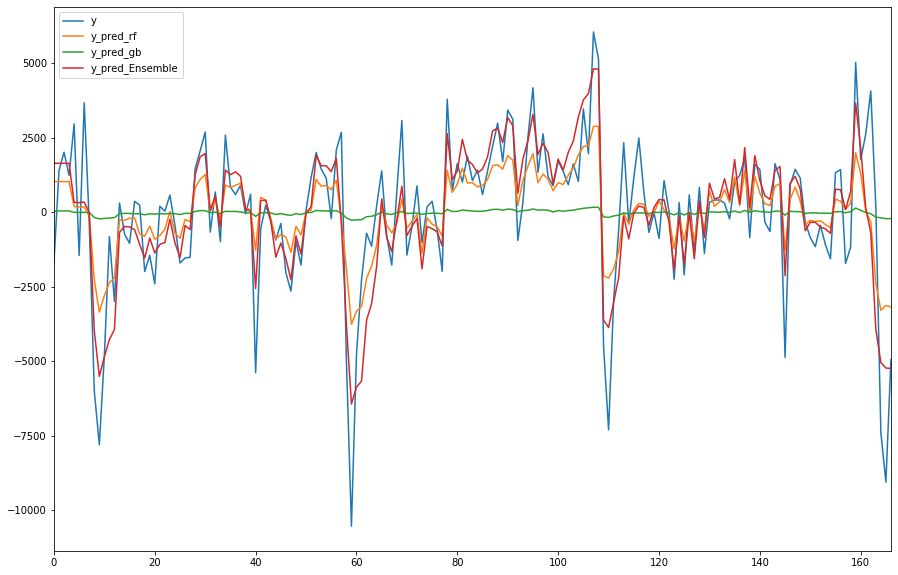

In [12]:
Model_comparison_prediction(df2_c)